In [ ]:
from google.colab import drive
import zipfile, os, urllib.request, glob, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Mounted at /content/drive


Τα δεδομένα μπορούν να βρεθούν από εδώ: https://challenge.isic-archive.com/data/#2019

Το σύνολο των δεδομένων αποτελείται από τρία υποσύνολα:



*   HAM10000: https://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf

*   BCN20000: https://arxiv.org/pdf/1908.02288.pdf

*   MSK Dataset: https://arxiv.org/pdf/1710.05006.pdf  και https://arxiv.org/pdf/1902.03368.pdf



Το train_meta.csv περιέχει metadata, επιπλέον πληροφορίες για κάθε εικόνα.

Τα δεδομένα του test dataset δεν έχουν ground truths, επομένως δεν μπορούν να χρησιμοποιηθούν.

In [ ]:
train_metadata = pd.read_csv('drive/MyDrive/train_meta.csv')
train_metadata.head()

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


In [ ]:
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB


Αρχικά βλέπουμε ότι τα δεδομένα μας περιέχουν 25331 εικόνες.

Κάθε γραμμή περιέχει πληροφορίες για μια συγκεκριμένη εικόνα των δεδομένων.
Τα πεδία είναι τα παρακάτω:

*   image:
Ένα μοναδικό id που ανατίθεται σε κάθε εικόνα των δεδομένων.

*   age_approx:
Η ηλικία του ανθρώπου στον οποίο ανήκει το δείγμα.

*   anatom_site_general:
Το μέρος του σώματος στο οποίο βρίσκεται η πληγή.

*   lesion_id:
Ένα id που ανατίθεται σε κάθε περιστατικό/πληγή.
Στα δεδομένα μας, υπάρχουν περιπτώσεις όπου πολλές εικόνες('image') αντιστοιχούν σε ένα lesion_id.

*   sex:
Το φύλο του ανθρώπου στον οποίο ανήκει το δείγμα.

Έλεγχος για την κατανομή των τιμών και το πλήθος των NaN values που περιέχονται σε κάθε στήλη.

In [ ]:
for current_column in ['lesion_id', 'anatom_site_general', 'sex']:
  print("\nNumber of NaN values in %s column: %d" %(current_column,train_metadata[current_column].isna().sum()))
  print("\nDistribution of the values of column %s:\n " %current_column)
  print(train_metadata[current_column].value_counts())


Number of NaN values in lesion_id column: 2084

Distribution of the values of column lesion_id:
 
BCN_0001728    31
BCN_0003369    27
BCN_0001321    26
BCN_0003196    24
BCN_0001954    21
               ..
HAM_0004752     1
HAM_0000667     1
HAM_0000240     1
HAM_0003075     1
BCN_0001014     1
Name: lesion_id, Length: 11847, dtype: int64

Number of NaN values in anatom_site_general column: 2631

Distribution of the values of column anatom_site_general:
 
anterior torso     6915
lower extremity    4990
head/neck          4587
upper extremity    2910
posterior torso    2787
palms/soles         398
oral/genital         59
lateral torso        54
Name: anatom_site_general, dtype: int64

Number of NaN values in sex column: 384

Distribution of the values of column sex:
 
male      13286
female    11661
Name: sex, dtype: int64


In [ ]:
train_metadata['age_approx'].isna().sum()

437

Αλλάζουμε τις τιμές από NaN σε Unknown για τις στήλες με string object και από NaN σε -5 για την age_approx στήλη.

In [ ]:
string_type_cols = ['image','anatom_site_general','lesion_id','sex']
numeric_type_cols = ['age_approx']

train_metadata[string_type_cols] = train_metadata[string_type_cols].fillna('Unknown')
train_metadata[numeric_type_cols] = train_metadata[numeric_type_cols].fillna(-5)
train_metadata.head()

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,Unknown,female
1,ISIC_0000001,30.0,anterior torso,Unknown,female
2,ISIC_0000002,60.0,upper extremity,Unknown,female
3,ISIC_0000003,30.0,upper extremity,Unknown,male
4,ISIC_0000004,80.0,posterior torso,Unknown,male


Για τα lesion_id που είναι unknown θεωρώ ότι το καθένα αναφέρεται σε ξεχωριστό δείγμα.

In [ ]:
def create_unique_lesion(x):

  current_les_id = x.lesion_id
  if current_les_id == 'Unknown':
    index_no = x.name
    x.lesion_id = 'Unknown' + str(index_no)

  return x

train_metadata = train_metadata.apply(create_unique_lesion, axis = 1)
train_metadata.head()

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,Unknown0,female
1,ISIC_0000001,30.0,anterior torso,Unknown1,female
2,ISIC_0000002,60.0,upper extremity,Unknown2,female
3,ISIC_0000003,30.0,upper extremity,Unknown3,male
4,ISIC_0000004,80.0,posterior torso,Unknown4,male


Έχουμε 13931 unique lesion_id που σημαίνει ότι, σε κάποιες πληγές αντιστοιχούν παραπάνω από μία φωτογραφίες. Ωστόσο, αυτές οι φωτογραφίες δεν είναι πανομοιότυπες (διαφορετικό zoom, διαφορετική γωνία, διαφορετική χρονική στιγμή λήψης...). Επομένως θεωρώ (και από τη στιγμή που περιέχονται στο dataset από τους δημιουργούς) ότι πρέπει να τις κρατήσω.

Ωστόσο, στον διαχωρισμό του dataset σε train/test, θα πρέπει να μην υπάρχουν φωτογραφίες που να έχουν το ίδιο lesion_id και ταυτόχρονα να περιέχονται σε διαφορετικό split των δεδομένων (θα πρέπει δηλαδή όλες οι φωτογραφίες από ένα lesion_id να περιέχονται είτε στο train είτε στο test).

Στη συνέχεια κάνω load τα ground truths από το train dataset.

In [ ]:
train_gt = pd.read_csv('drive/MyDrive/ISIC_2019_Training_GroundTruth.csv')
train_gt.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Αφαιρώ τις 9 στήλες και προσθέτω μία που θα περιέχει έναν αριθμό από 0 μέχρι 8:

*   0 -> AK
*   1 -> BCC
*   2 -> BKL
*   3 -> DF
*   4 -> MEL
*   5 -> NV
*   6 -> SCC
*   7 -> VASC
*   8 -> UNK


In [ ]:
def create_one_column(x):
  for counter,label in enumerate(['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC', 'UNK']):
    if x[label] == 1.0:
      return counter

train_gt['category'] = train_gt.apply(create_one_column, axis = 1)
train_gt.drop(columns = ['MEL','NV','BCC','AK','BKL','DF','VASC','SCC','UNK'], inplace = True)
train_gt.head()

,image,category
0,ISIC_0000000,5
1,ISIC_0000001,5
2,ISIC_0000002,4
3,ISIC_0000003,5
4,ISIC_0000004,4


Ελέγχω 'πόσο περιέχεται' κάθε κλάση στα δεδομένα μας και παρατηρούμε ότι η UNK κλάση (δηλαδή φωτογραφίες που δεν ανήκουν σε καμία από τις υπόλοιπες 8 κλάσεις) δεν έχει καθόλου δεδομένα.


In [ ]:
train_gt['category'].value_counts()

5    12875
4     4522
1     3323
2     2624
0      867
6      628
7      253
3      239
Name: category, dtype: int64

Τέλος, κάνω merge τα metadata με τα ground truths.

In [ ]:
dataset = pd.merge(train_gt,train_metadata,on = 'image')
dataset.head()

,image,category,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,5,55.0,anterior torso,Unknown0,female
1,ISIC_0000001,5,30.0,anterior torso,Unknown1,female
2,ISIC_0000002,4,60.0,upper extremity,Unknown2,female
3,ISIC_0000003,5,30.0,upper extremity,Unknown3,male
4,ISIC_0000004,4,80.0,posterior torso,Unknown4,male


In [ ]:
dataset.sex.value_counts()

male       13286
female     11661
Unknown      384
Name: sex, dtype: int64

In [ ]:
dataset.loc[dataset.sex == 'Unknown'].category.value_counts()

5    271
4     81
2     23
1      6
0      3
Name: category, dtype: int64

In [ ]:
dataset.anatom_site_general.value_counts()

anterior torso     6915
lower extremity    4990
head/neck          4587
upper extremity    2910
posterior torso    2787
Unknown            2631
palms/soles         398
oral/genital         59
lateral torso        54
Name: anatom_site_general, dtype: int64

In [ ]:
dataset.loc[dataset.anatom_site_general == 'Unknown'].category.value_counts()

5    2094
2     275
4     127
1      72
7      31
0      22
6       6
3       4
Name: category, dtype: int64

Έλεγχος της συσχέτισης των πεδίων: category, age_approx, anatom_site_general, sex.

In [ ]:
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


Έλεγχος συσχέτισης ανάμεσα στο age_approx και το category.

In [ ]:
import scipy.stats as ss

temp_dataset = dataset.loc[(dataset['age_approx'] != -5)]

def calculate_eta_squared(kruskal_statistic, num_groups, total_observations):
    eta_squared = (kruskal_statistic - num_groups + 1) / (total_observations - num_groups)
    return eta_squared

vars_to_check = ['age_approx']

for i in vars_to_check:

  print("Print stats for variable", i)
  #shapiro-wilk test for normality
  print(ss.shapiro(np.array(temp_dataset[i].tolist())))

  listes = []
  total_observations = 0
  for group in temp_dataset.groupby('category'):

    total_observations += len(group[1][i].tolist())
    listes.append(group[1][i].tolist())

  #kruskal-wallis test of association
  statistic, _ = ss.kruskal(*listes)
  eta_k = calculate_eta_squared(statistic,8,total_observations)
  print(eta_k)

Print stats for variable age_approx
ShapiroResult(statistic=0.9762924909591675, pvalue=0.0)
0.285936091403573


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Associations with category:  [0.17269676 1.         0.09110467]


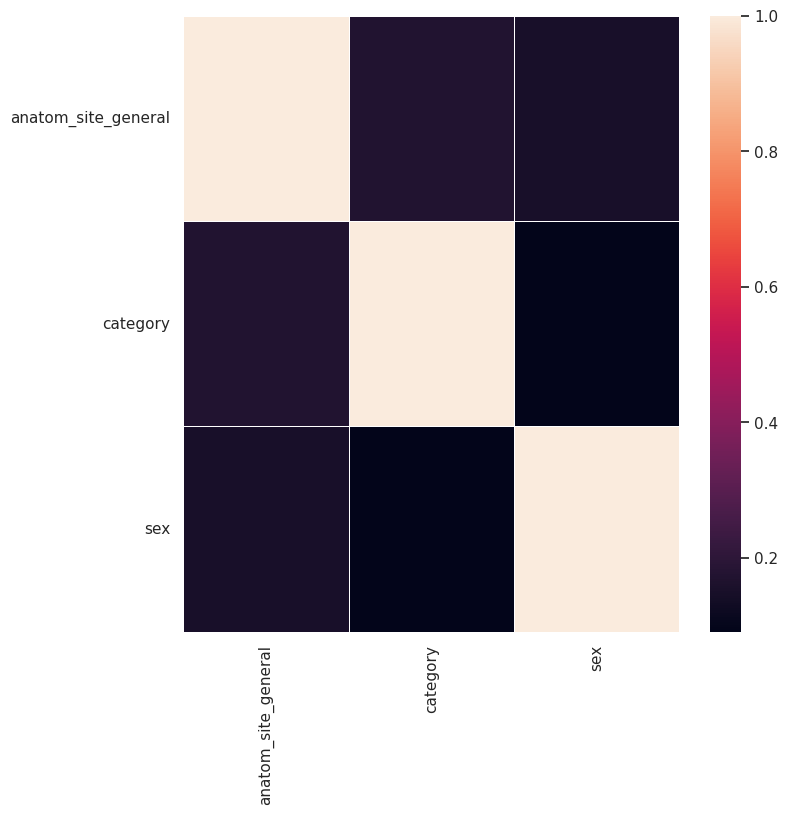

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt

categorical_vars = sorted(['anatom_site_general', 'sex', 'category'])

total_features = len(categorical_vars)
correlations_array = np.empty((total_features,total_features))

for counter_i,i in enumerate(categorical_vars):

  for counter_k,k in enumerate(categorical_vars):

    temp_df = dataset.loc[(dataset[i] != 'Unknown') & (dataset[k] != 'Unknown')]

    correlations_array[counter_i][counter_k] = cramers_v(temp_df[i], temp_df[k])

print("Associations with category: ", correlations_array[1])
sns.set(rc={'figure.figsize':(8,8)})
ax = sns.heatmap(correlations_array, linewidth=0.5)
ax.set_xticklabels(categorical_vars)
ax.set_yticklabels(categorical_vars)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [ ]:
dataset.to_csv('drive/MyDrive/dataset.csv',index = False)

Στη συνέχεια, θα κάνω κάποια plots πάνω στην κατανομή των δεδομένων.
Επειδή όπως περιέγραψα παραπάνω υπάρχουν πολλές φωτογραφίες που αντιστοιχούν στην ίδια πληγή(και επομένως τα metadata θα είναι ίδια), θα κάνω την ανάλυση με και χωρίς διπλότυπα δεδομένα (όσον αφορά το lesion_id).



In [ ]:
dataset_without_dp = dataset.drop_duplicates(subset = ['lesion_id'])
print('Length of dataset without duplicates is: ', len(dataset_without_dp))

Length of dataset without duplicates is:  13931


[867, 3323, 2624, 239, 4522, 12875, 628, 253]
[324, 1310, 1467, 113, 1676, 8644, 262, 135]


Text(0.5, 1.0, 'Κατανομή του πεδίου:category χωρίς διπλότυπα')

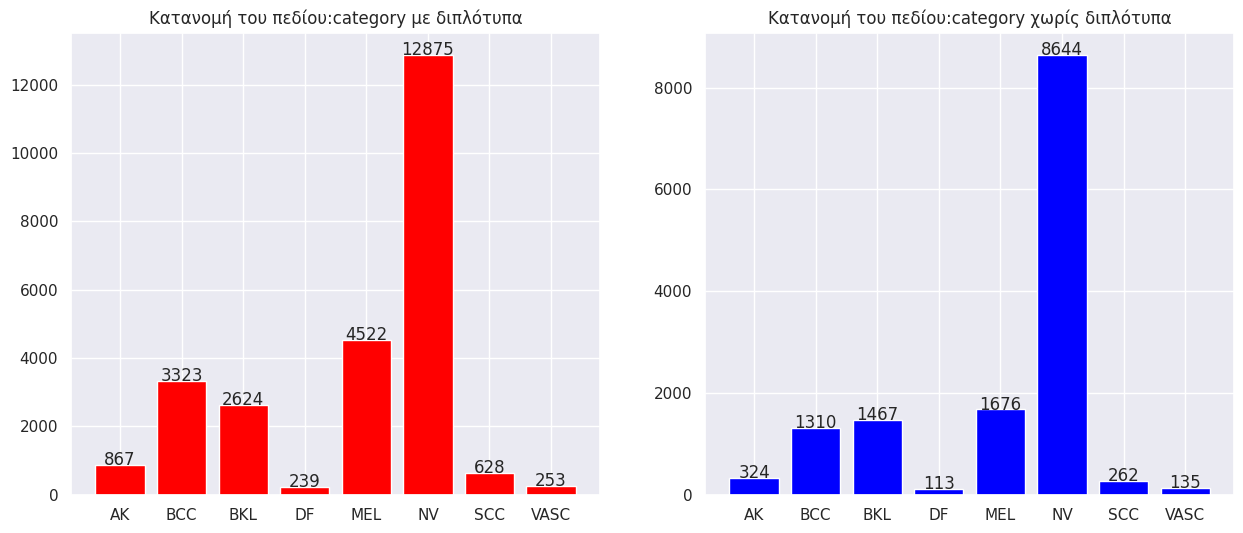

In [ ]:
categories = ['AK','BCC','BKL','DF','MEL','NV','SCC','VASC']

categories_values_dup = [0] * 8
for i in dataset.category.value_counts().to_dict().items():
  categories_values_dup[i[0]] = i[1]
print(categories_values_dup)

categories_values_no_dup = [0] * 8
for i in dataset_without_dp.category.value_counts().to_dict().items():
  categories_values_no_dup[i[0]] = i[1]
print(categories_values_no_dup)

def addlabels(x,y):
  for i in range(len(x)):
    plt.text(i, y[i], y[i], ha = 'center')

fig = plt.figure(figsize = (15, 6))

plt.subplot(1,2,1)
plt.bar(categories,categories_values_dup,color = 'red')

addlabels(categories,categories_values_dup)
plt.title("Κατανομή του πεδίου:category με διπλότυπα")

plt.subplot(1,2,2)
plt.bar(categories,categories_values_no_dup,color = 'blue')

addlabels(categories,categories_values_no_dup)
plt.title("Κατανομή του πεδίου:category χωρίς διπλότυπα")

Αρχικά, παρατηρούμε ότι το target των δεδομένων μας(category) είναι imbalanced, καθώς κάποιες κατηγορίες εμφανίζονται πολύ συχνότερα από κάποιες άλλες (κυρίως η 1: NV).
Επομένως, είναι σημαντικό να εφαρμοστούν τεχνικές για την αντιμετώπιση αυτού του προβλήματος (oversampling, undersampling,weighted classes training).

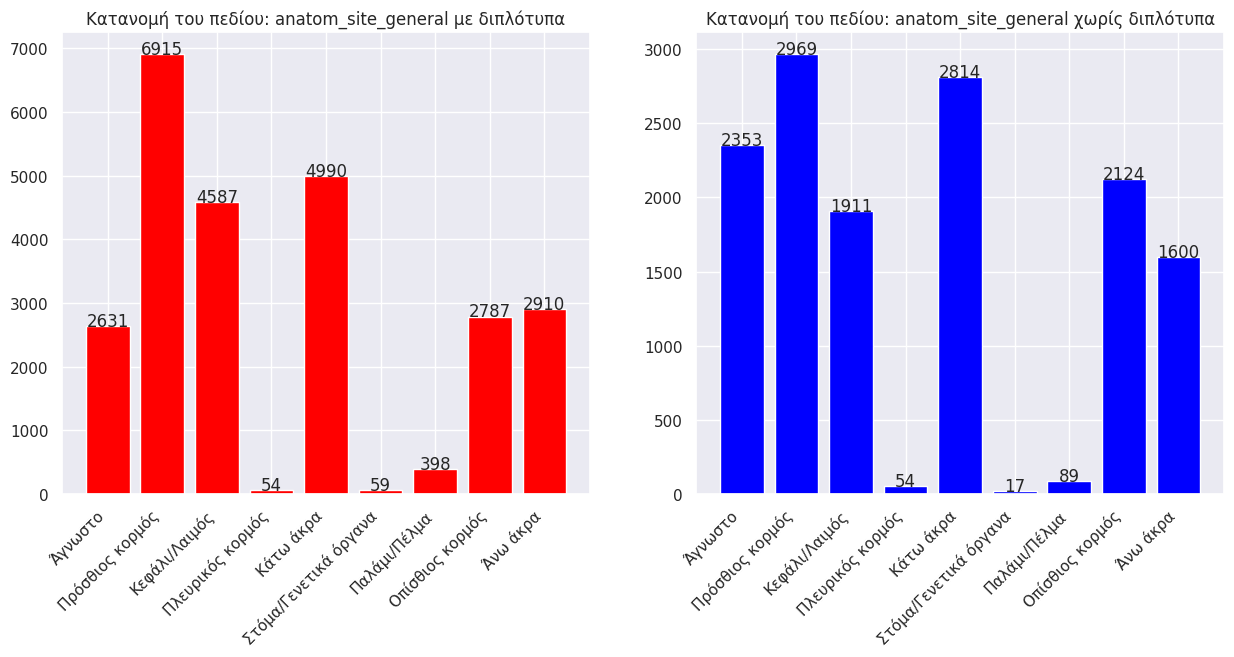

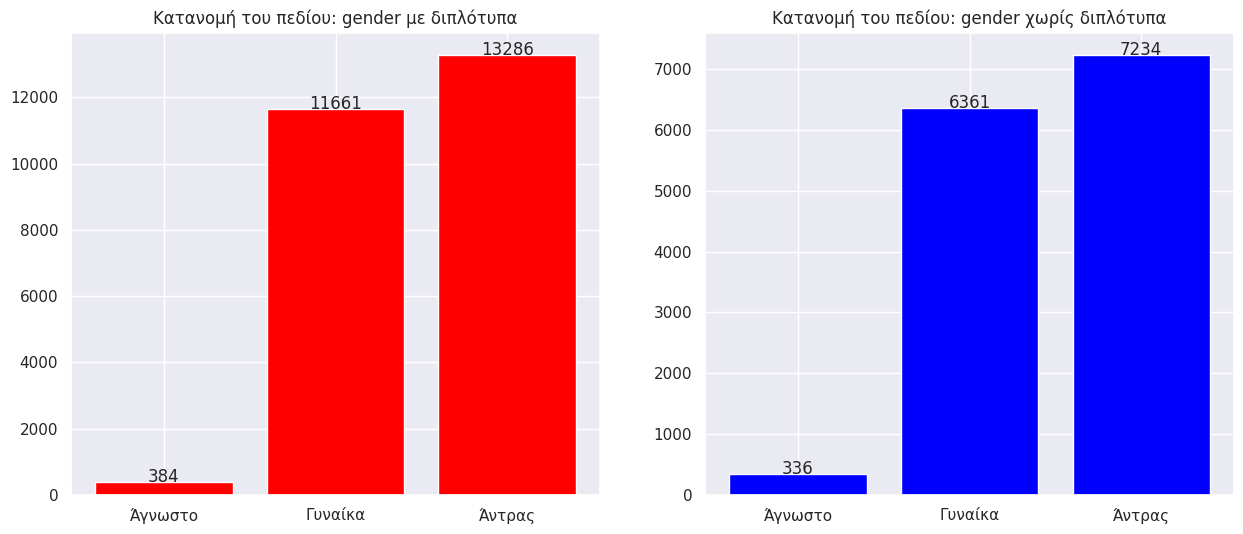

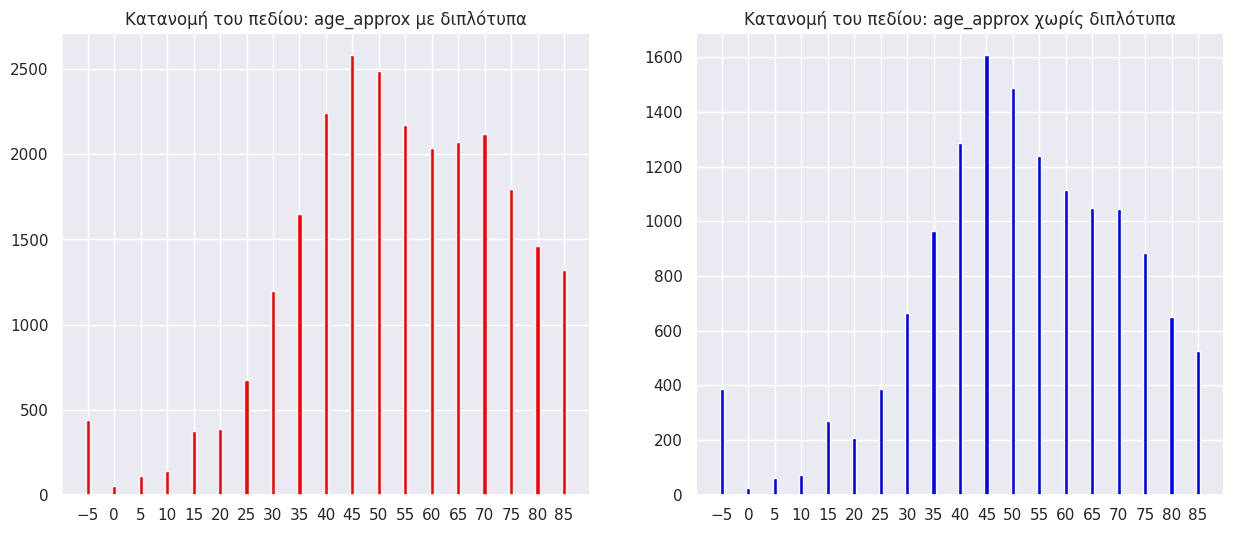

In [ ]:
gender_name_mapping = {"male": 'Άντρας', 'female':'Γυναίκα', 'Unknown': 'Άγνωστο'}
region_name_mapping = {"anterior torso": "Πρόσθιος κορμός", "lower extremity": "Κάτω άκρα", "upper extremity": "Άνω άκρα", "posterior torso": "Οπίσθιος κορμός", "lateral torso": "Πλευρικός κορμός", "head/neck":"Κεφάλι/Λαιμός", "Unknown":"Άγνωστο", "palms/soles":"Παλάμι/Πέλμα", "oral/genital": "Στόμα/Γενετικά όργανα"}

def addlabels(x,y):
  for i in range(len(x)):
    plt.text(i, y[i], y[i], ha = 'center')

def plot_distr(column, translation_dict = None,plot_number = 1, rotate_xticks = 0):

  fig = plt.figure(figsize = (15, 6))

  for ci,i in enumerate([(dataset,'red',' με διπλότυπα'),(dataset_without_dp,'blue',' χωρίς διπλότυπα')],1):

    plt.subplot(1,2,ci)

    temp_dict = i[0][column].value_counts().to_dict()
    myKeys = list(temp_dict.keys())
    myKeys.sort()
    column_distr = {k: temp_dict[k] for k in myKeys}

    if translation_dict:
      column_distr_keys_translated = []

      for j in column_distr.keys():
        column_distr_keys_translated.append(translation_dict[j])
    else:
      column_distr_keys_translated = column_distr.keys()

    plt.bar(column_distr_keys_translated, column_distr.values(),color = i[1])

    if plot_number:
      addlabels(list(column_distr_keys_translated), list(column_distr.values()))
    plt.xticks(list(column_distr_keys_translated))
    if rotate_xticks:
      plt.xticks(rotation=rotate_xticks, ha='right')

    if column == 'sex':
      name_of_column = 'gender'
    else:
      name_of_column = column
    plt.title('Κατανομή του πεδίου: ' + name_of_column + i[2])

  return

plot_distr('anatom_site_general',region_name_mapping,1,45)
plot_distr('sex',gender_name_mapping,1,0)
plot_distr('age_approx',0,0)

plt.show()